# Hybrid SE detection using Deep learning models

## Fetch the data

In [1]:
!wget https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip
!wget https://raw.githubusercontent.com/npolatidis/seader/refs/heads/master/dialogues_dataset_formatted_added_links.csv

--2024-11-04 21:39:25--  https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘archive.ics.uci.edu’
--2024-11-04 21:39:25--  https://raw.githubusercontent.com/npolatidis/seader/refs/heads/master/dialogues_dataset_formatted_added_links.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘raw.githubusercontent.com’


### First exploring the SMS Spam Collection

In [2]:
# Unzip the dataset
from zipfile import ZipFile

with ZipFile("sms+spam+collection.zip", 'r') as zip:
    zip.extractall()

The dataset is a text file. So we can read in the different lines and convert the whole dataset into a DataFrame

In [3]:
data_dict = {'label':[], 'text': []}

with open("SMSSpamCollection", 'r') as file:
    for line in file:
        # Split the line on the first tab or whitespace
        parts = line.split(maxsplit=1)
        
        # Check that we have at least two parts: label and text
        if len(parts) == 2:
            label = parts[0].strip()
            text = parts[1].strip().strip('"')  # Remove surrounding quotes if any

            # Append to dictionary lists
            data_dict["label"].append(label)
            data_dict["text"].append(text)


In [4]:
# view a sample of the entries

for i in range(10):
    print(f"Label: {data_dict['label'][i]}, Text: {data_dict['text'][i]}")

Label: ham, Text: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Label: ham, Text: Ok lar... Joking wif u oni...
Label: spam, Text: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Label: ham, Text: U dun say so early hor... U c already then say...
Label: ham, Text: Nah I don't think he goes to usf, he lives around here though
Label: spam, Text: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
Label: ham, Text: Even my brother is not like to speak with me. They treat me like aids patent.
Label: ham, Text: As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
Label: spam, Text: WINNER!! As a valued network customer 

In [5]:
# convert the dictionary to a dataframe
import pandas as pd

sms_df = pd.DataFrame(data_dict)
sms_df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
sms_df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


In [7]:
sms_df.describe()

,label,text
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


In [8]:
sms_df.isnull().sum()

label    0
text     0
dtype: int64

In [9]:
sms_df.duplicated().sum()

np.int64(414)

In [10]:
# drop duplicated values 
sms_df = sms_df.drop_duplicates(keep="first")

In [11]:
sms_df.duplicated().sum()

np.int64(0)

In [12]:
sms_df.shape

(5160, 2)

### Now to check out the Dialogues dataset

In [13]:
# read in csv file
import csv


dialogues_df = pd.read_csv("dialogues_dataset_formatted_added_links.csv", quoting=csv.QUOTE_NONE, on_bad_lines='skip', engine='python')
# TODO: error on line 69 - got 8 columns instead of 7
dialogues_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   voice_id      138 non-null    int64 
 1   num_caller    138 non-null    int64 
 2   num_receiver  138 non-null    int64 
 3   date          138 non-null    int64 
 4   time          138 non-null    int64 
 5   is_attack     138 non-null    bool  
 6   dialog        138 non-null    object
dtypes: bool(1), int64(5), object(1)
memory usage: 6.7+ KB


In [14]:
dialogues_df.head()

,voice_id,num_caller,num_receiver,date,time,is_attack,dialog
0,4444444444,6094660035,9082456893,20050215,2050,False,This is mike smith from orange. I am a sales r...
1,5555555555,6094660036,9082456847,20050221,1254,False,Hi this is mike jones from orange. I am the sa...
2,3333333333,6094660038,9082456829,20050422,1315,True,I am john doe from apple computers where I am ...
3,2222222222,6094660035,9082456896,20050515,1150,True,This is john candy from apple. I am a computer...
4,1111111111,4879301873,9082456894,20050524,1433,False,hi this is moe sislack from moes tavern. I am ...


In [15]:
print(dialogues_df['is_attack'].value_counts())

is_attack
True     72
False    66
Name: count, dtype: int64


In [16]:
dialogues_df.describe()

,voice_id,num_caller,num_receiver,date,time
count,1.380000e+02,1.380000e+02,1.380000e+02,1.380000e+02,138.000000
mean,3.204443e+09,6.013426e+09,9.082457e+09,2.005654e+07,1263.007246
std,2.663748e+09,1.042616e+09,8.307955e+01,1.089949e+04,297.614297
min,1.010101e+09,4.247590e+09,9.082457e+09,2.002051e+07,834.000000
25%,1.111111e+09,4.879302e+09,9.082457e+09,2.005054e+07,1035.000000
50%,2.222222e+09,6.094660e+09,9.082457e+09,2.005567e+07,1244.000000
75%,4.166667e+09,6.094660e+09,9.082457e+09,2.006049e+07,1437.500000
max,1.000000e+10,8.542360e+09,9.082457e+09,2.013101e+07,2050.000000


In [17]:
sms_df['label'] = sms_df['label'].replace({'ham':'no', 'spam':'yes'})
sms_df.head()

/tmp/ipykernel_4721/2071947822.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sms_df['label'] = sms_df['label'].replace({'ham':'no', 'spam':'yes'})


,label,text
0,no,"Go until jurong point, crazy.. Available only ..."
1,no,Ok lar... Joking wif u oni...
2,yes,Free entry in 2 a wkly comp to win FA Cup fina...
3,no,U dun say so early hor... U c already then say...
4,no,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
dialogues_df['is_attack'] = dialogues_df['is_attack'].replace({True:'yes', False:'no'})
dialogues_df.head()

,voice_id,num_caller,num_receiver,date,time,is_attack,dialog
0,4444444444,6094660035,9082456893,20050215,2050,no,This is mike smith from orange. I am a sales r...
1,5555555555,6094660036,9082456847,20050221,1254,no,Hi this is mike jones from orange. I am the sa...
2,3333333333,6094660038,9082456829,20050422,1315,yes,I am john doe from apple computers where I am ...
3,2222222222,6094660035,9082456896,20050515,1150,yes,This is john candy from apple. I am a computer...
4,1111111111,4879301873,9082456894,20050524,1433,no,hi this is moe sislack from moes tavern. I am ...


In [19]:
# our interest is in the labels and text
dialogues_df = dialogues_df.drop(['voice_id', 'num_caller', 'num_receiver', 'date', 'time'], axis=1)

In [20]:
dialogues_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   is_attack  138 non-null    object
 1   dialog     138 non-null    object
dtypes: object(2)
memory usage: 2.3+ KB


In [21]:
# renaming colums
sms_df = sms_df.rename(columns={'label':'is_suspicious'})
dialogues_df = dialogues_df.rename(columns={'is_attack':'is_suspicious', 'dialog':'text'})

In [22]:
print(sms_df.columns)
print(dialogues_df.columns)

Index(['is_suspicious', 'text'], dtype='object')
Index(['is_suspicious', 'text'], dtype='object')


Combining both dataframe

In [23]:
combined_df = pd.concat([sms_df, dialogues_df], ignore_index=True)
combined_df

,is_suspicious,text
0,no,"Go until jurong point, crazy.. Available only ..."
1,no,Ok lar... Joking wif u oni...
2,yes,Free entry in 2 a wkly comp to win FA Cup fina...
3,no,U dun say so early hor... U c already then say...
4,no,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5293,yes,hi this is jenny heights from notre dame. I am...
5294,yes,hi this is your sales rep samuel pitt from roc...
5295,yes,hello I am a sales rep from orange. oh sorry b...
5296,yes,Hi this is justin jones I am a sales rep from ...


In [24]:
print(combined_df['is_suspicious'].value_counts())

is_suspicious
no     4584
yes     714
Name: count, dtype: int64


Checking the label distribution

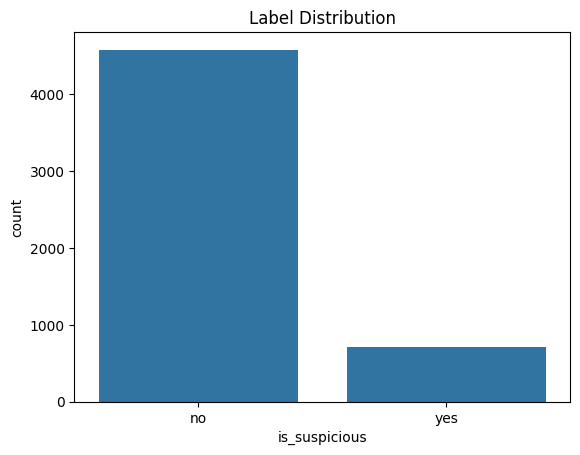

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='is_suspicious', data=combined_df)
plt.title("Label Distribution")
plt.savefig('images/labels_distribution.png')
plt.show()

The dataset is greatly imbalanced as there are more instances of the non-suspicious class. This could affect the model as it could learn to favour the more common label. In a later cell, we will balance the dataset using a Synthetic Data Generation technique (ie Synthethic Minority Over-sampling Technique aka SMOTE)

Checking text length distribution|

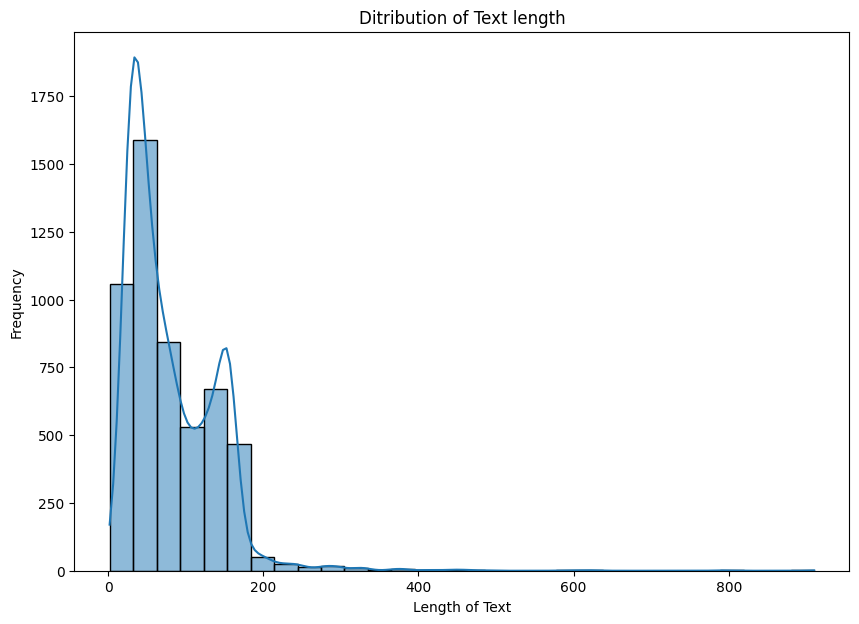

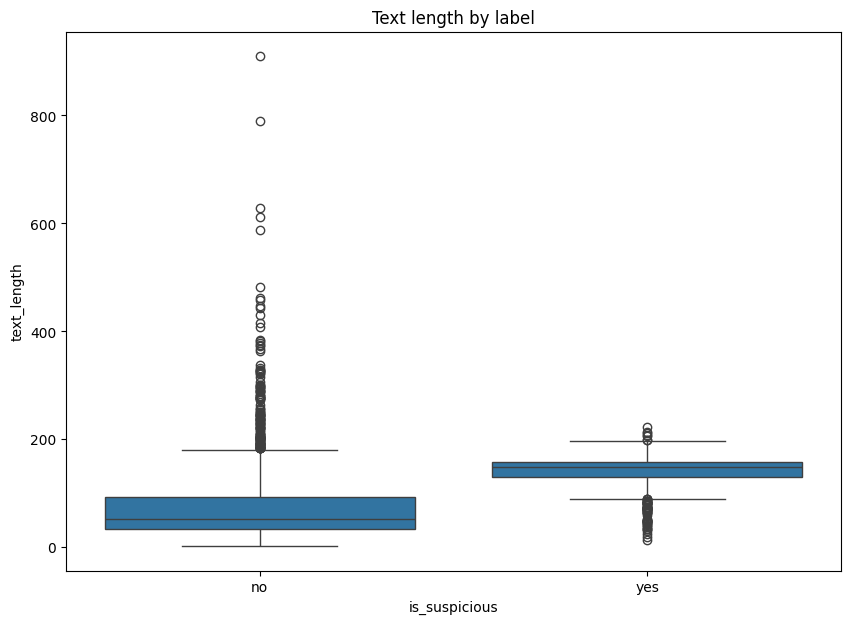

In [ ]:
# new column
combined_df['text_length'] = combined_df['text'].apply(len)

# plot distribution
plt.figure(figsize=(10, 7))
sns.histplot(combined_df['text_length'], bins=30, kde=True)
plt.title("Ditribution of Text length")
plt.xlabel("Length of Text")
plt.ylabel("Frequency")
plt.savefig('images/text_length_by_frequency.png')
plt.show()

plt.figure(figsize=(10, 7))
sns.boxplot(x="is_suspicious", y='text_length', data=combined_df)
plt.title("Text length by label")
plt.savefig('images/text_length_by_label.png')
plt.show()

The histogram plot shows that most text the dataset contains are relatively short. The most common text length in the dataset is possibly betweeen 0 and 50 characters long.From the box plot we can see that although shorter messages correlate more with suspicious content. Non-suspicious messages also have short lengths, but they have more outliers that are longer than the majority

Checking Word Count and Average Words for each text

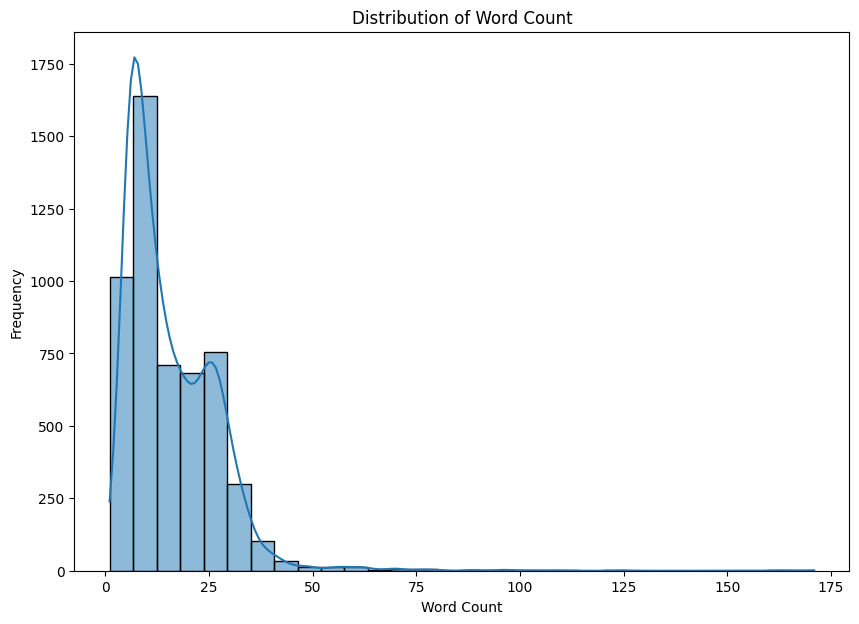

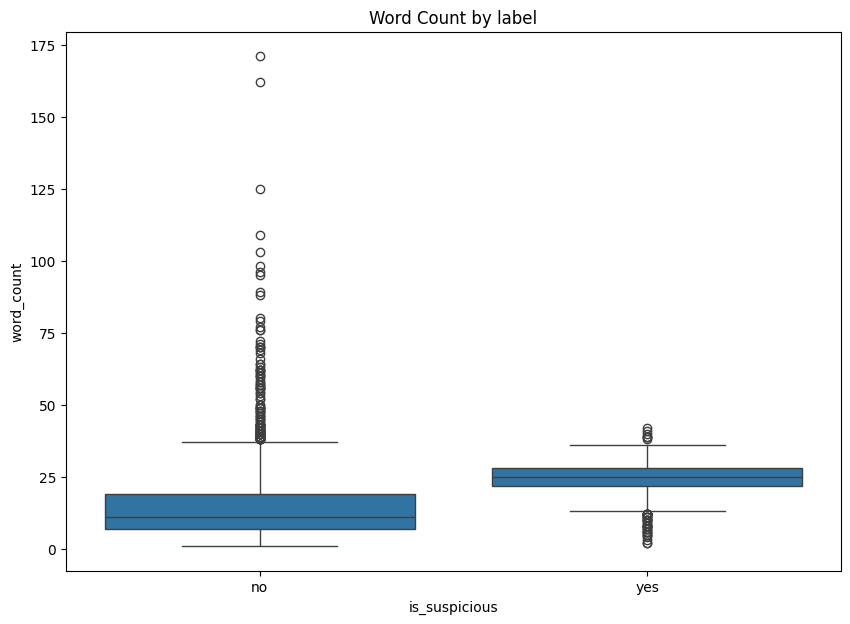

In [ ]:
combined_df['word_count'] = combined_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 7))
sns.histplot(combined_df['word_count'], bins=30, kde=True)
plt.title("Distribution of Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.savefig('images/word_count_by_frequency.png')
plt.show()

# compare word count across labels
plt.figure(figsize=(10, 7))
sns.boxplot(x='is_suspicious', y='word_count', data=combined_df)
plt.title("Word Count by label")
plt.savefig('images/word_count_by_label.png')
plt.show()

Common word analysis using WordCloud

In [28]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter

# download stopwords
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [ ]:
stop_words = set(stopwords.words('english'))

# function to join all text in a class and filter stop words
def create_word_cloud(label):
    text = " ".join(combined_df[combined_df['is_suspicious'] == label]['text'])
    filtered_words = " ".join([word for word in text.split() if word.lower() not in stop_words])
    wordcloud = WordCloud(width=600, height=300, background_color='white').generate(filtered_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {"Suspicious" if label == 'yes' else "Not suspicious"} Messages")
    plt.savefig(f'images/{"Suspicious" if label == 'yes' else "Not suspicious"}_word_cloud.png')
    plt.show()

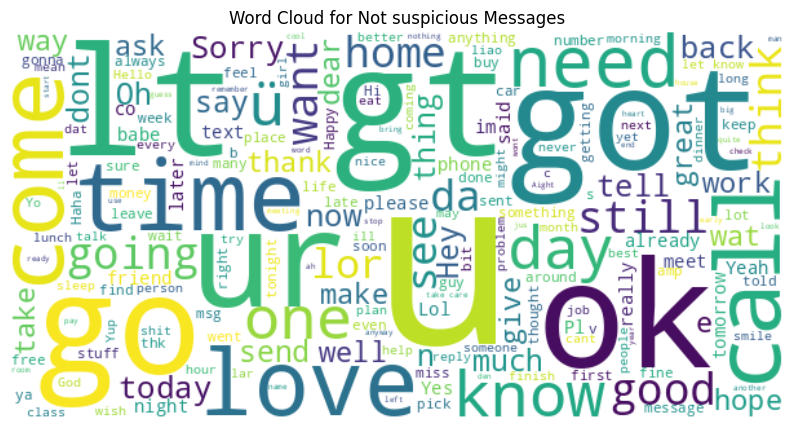

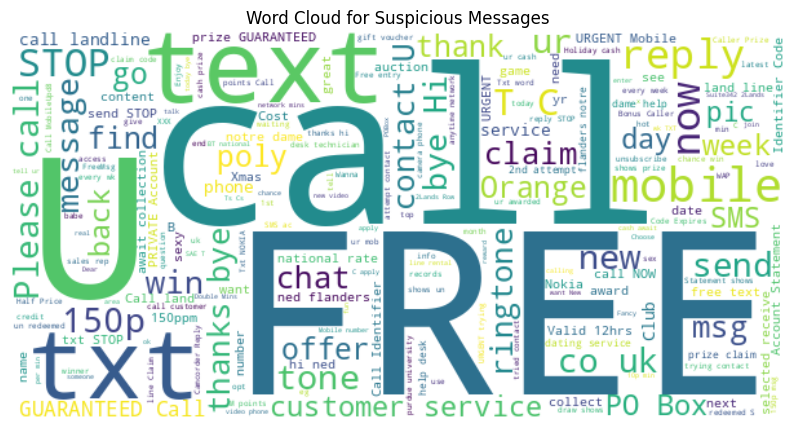

In [30]:
# Generate word clouds for each label
for label in combined_df['is_suspicious'].unique():
    create_word_cloud(label)

N-gram Analysis

In [31]:
from nltk import ngrams

def get_ngrams(text_series, n=2):
    all_ngrams = []
    for text in text_series:
        _ngrams = ngrams(text.split(), n)
        all_ngrams.extend(list(_ngrams))
    return Counter(all_ngrams).most_common(20)

# print top n-grams for each label
for label in combined_df['is_suspicious'].unique():
    print(f"Top n-grams for {"Suspicious" if label == 'yes' else "Not suspicious"} messages: ")
    n_grams = get_ngrams(combined_df[combined_df['is_suspicious'] == label]['text'], 3)
    for gram, count in n_grams:
        print(f"{gram}: {count}")

Top n-grams for Not suspicious messages: 
('I', 'am', 'a'): 46
('I', 'want', 'to'): 22
('would', 'you', 'like'): 22
('Hi', 'this', 'is'): 22
('I', 'miss', 'you'): 19
('you', 'like', 'to'): 17
('I', 'am', 'the'): 17
('sales', 'rep.', 'would'): 16
('rep.', 'would', 'you'): 16
('I', 'love', 'you'): 15
('.', '.', '.'): 15
('to', 'buy', 'some'): 15
('Do', 'have', 'a'): 14
('let', 'me', 'know'): 14
('give', 'me', 'a'): 14
('Have', 'a', 'great'): 14
('like', 'to', 'buy'): 14
('buy', 'some', 'software.'): 14
('to', 'go', 'to'): 13
('be', 'able', 'to'): 13
Top n-grams for Suspicious messages: 
('I', 'am', 'a'): 54
('Hi', 'this', 'is'): 28
('hi', 'this', 'is'): 25
('have', 'won', 'a'): 19
('this', 'is', 'ned'): 19
('is', 'ned', 'flanders'): 19
('ned', 'flanders', 'from'): 19
('from', 'notre', 'dame.'): 18
('notre', 'dame.', 'I'): 17
('dame.', 'I', 'am'): 17
('prize', 'GUARANTEED.', 'Call'): 16
('Account', 'Statement', 'for'): 15
('university.', 'I', 'am'): 15
('cash', 'or', 'a'): 14
('from', 'la

### Special character and URL analysis
Social engineering attacks tend to contain features like URLS or special characters and phrases to indicate ugency, we will be comparing the urgency features and url counts for both labels

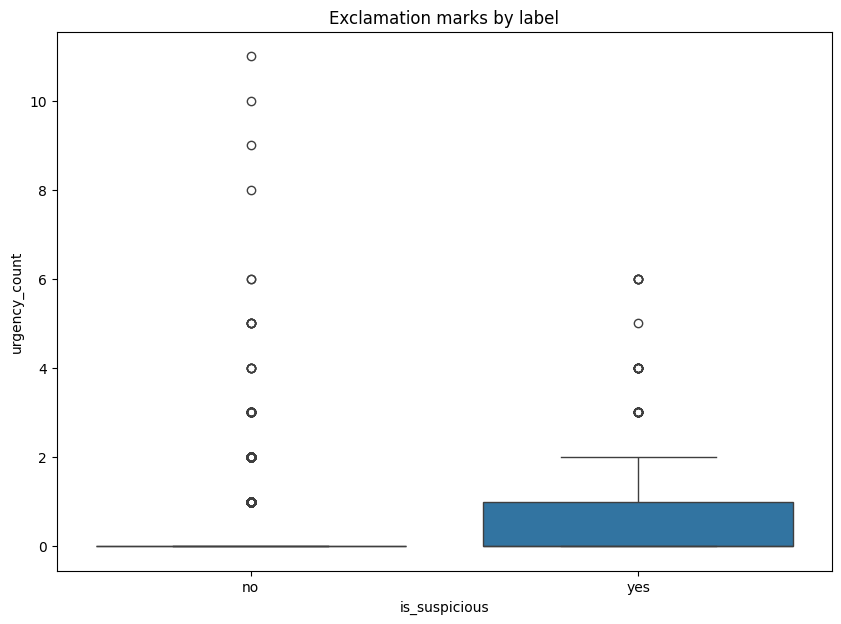

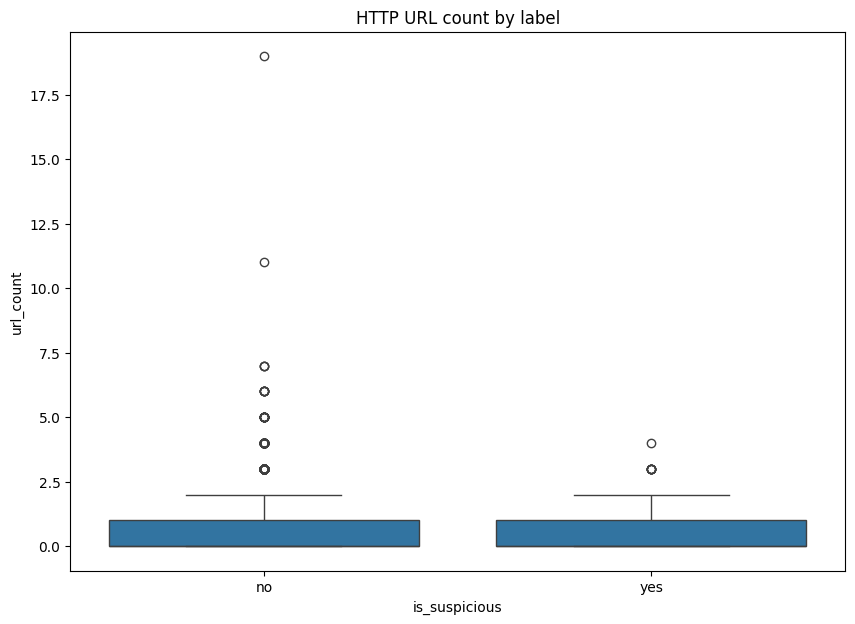

In [ ]:
import re

combined_df['urgency_count'] = combined_df['text'].apply(lambda x: x.count('!') + x.lower().count('urgent') + x.lower().count('quick') + x.lower().count('asap'))
# combined_df["question_count"] = combined_df['text'].apply(lambda x: x.count('?'))

url_pattern = r'https?://[^\s]+|www\.[^\s]+|\S+\.\S+'
combined_df['url_count'] = combined_df['text'].apply(lambda x: len(re.findall(url_pattern, x)))
# combined_df['short_link_count'] = 

plt.figure(figsize=(10,7))
sns.boxplot(x='is_suspicious', y='urgency_count', data=combined_df)
plt.title("Exclamation marks by label")
plt.savefig('images/urgency_count_by_labels.png')
plt.show()

plt.figure(figsize=(10,7))
sns.boxplot(x='is_suspicious', y='url_count', data=combined_df)
plt.title("HTTP URL count by label")
plt.savefig('images/url_count_by_label.png')
plt.show()


For this dataset, the suspicious messages contain more indications of urgency than non-suspicious messages. But for urls there are roughly the same in number.

### Correlation Analysis


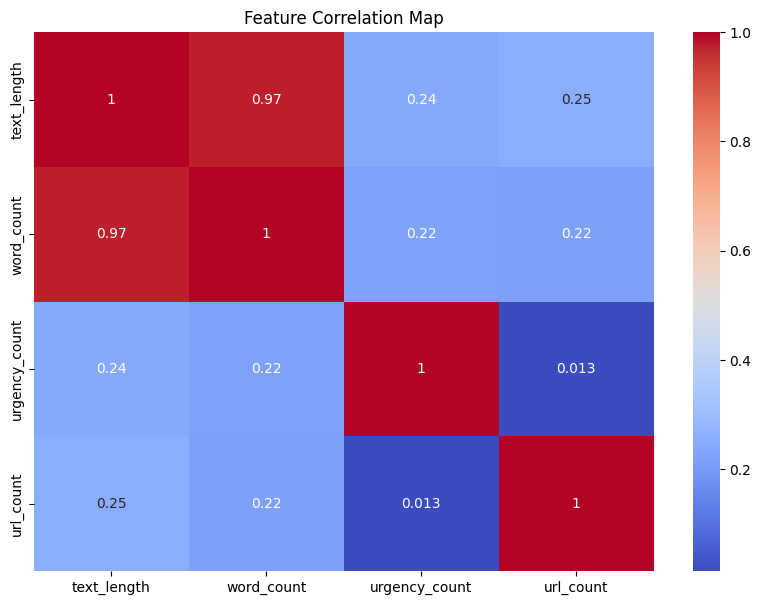

In [33]:
correlation_matrix = combined_df[['text_length', 'word_count', 'urgency_count', 'url_count']].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Map")
plt.savefig('correlation_map.png')
plt.show()